In [1]:
### Imports
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import ImageColorGenerator

In [31]:
pd.set_option("display.max_rows", None)

# Preprocessing of Text for Analysis Purposes

## Import the new dataframe
(that has artist names removed from transcripts)

In [2]:
df = pd.read_json('../raw_data/df_all_clean .json')

In [ ]:
len(df)

## Cleaning Functions

In [3]:
### Specific functions to our data - Scraps from the Loft and BBC

# remove notes (Bo Burnham Only)
def clean_bo(text):
    txt = text
    for note in '♫♪':
        txt = txt.replace(note, '')
    return txt

def remove_music(text):
    text = re.sub('♪.*?♪', '', text) # remove ♪ stuff that looks like this ♪
    text = re.sub('♫.*?♫', '', text) # remove ♫ stuff that looks like this ♫
    return text

def remove_bracketed(text):
    text = re.sub('\[.*?\]', '', text) # remove [stuff that looks like this]
    text = re.sub('\(.*?\)', '', text) # remove (stuff that looks like this)
    return text

def remove_speaker_tags(text):
    text = re.sub('\s[\w-]+( \w+)?:\s', ' ', text) # remove Word: or Word word: with a newline or space before
    return text

def remove_info(text):
    text = re.sub('subtitle(s)? by .*', '', str(text)) # remove subtile(s) by xxxx
    text = re.sub('(a)? netflix (original )?(comedy )?(special ?)?', '', text) # remove A Netflix Original Comedy Special
    text = re.sub('(this )?(programme )?(contains )?(very |some )?strong language( |\.)', '', text) # remove strong language
    text = re.sub('adult humou?r( |\.?)?', '', text) # remove adult humour
    text = re.sub('(original )?air date', '', text) # remove air date
    return text

In [4]:
# general functions for text pre-processing
def remove_punc(text, chars):
    txt = text
    for punc in chars:
        txt = txt.replace(punc, '')
    return txt

def remove_num(text):
    return ''.join(char for char in text if not char.isdigit())

def remove_stopw(text, word_list):
    word_tokens = word_tokenize(text)
    return ' '.join(w for w in word_tokens if not w in word_list)

def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split(' ') if len(lemmatizer.lemmatize(word))>2)

In [5]:
lemmatizer_dict = {'got': 'get',
                  'gon': 'go',
                  'said': 'say',
                   'saying': 'say',
                  'fucking': 'fuck',
                  'went': 'go',
                  'finding': 'find',
                  'getting': 'get'}

def manual_lemmatizer(text):
    for k, v in lemmatizer_dict.items():
        text = text.replace(k, v)
    return text

## Modifying & applying removal lists 

In [6]:
clean_df = df.copy()

In [8]:
clean_df['full_transcript_clean'] = clean_df['full_transcript'].apply(remove_bracketed)
### clean Bo before removing music
clean_df['full_transcript_clean'][clean_df['artist']=='Bo Burnham'] = clean_df[
    'full_transcript_clean'][clean_df['artist']=='Bo Burnham'].apply(clean_bo)

/var/folders/s8/jf61hd8n2cj411r4h4mdpyf00000gn/T/ipykernel_90717/259179323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['full_transcript_clean'][clean_df['artist']=='Bo Burnham'] = clean_df[


In [9]:
### additional words to remove from the scripts
words_to_remove = ['thank', 'cheering', 'recorded', 'applause', 'laughter', 'laughing', 'murmuring', 'chatter',
                       'aired', 'filmed', 'ladies', 'gentlemen', 'welcome', 'stage', 'transcript', 'netflix',
                  'apollo', 'like', 'goodnight', 'mutter', 'noo', 'nuh', 'oof', 'maan', 'fuck', 'cause', 'okay', 
                   'hey', 'also', 'someone', 'somebody', 'everybody', 'also', 'part' , 'sometimes', 'maybe', 
                   'three', 'second', 'everything', 'minute', 'name', 'kind', 'point', 'yeah', 'hello', 'one', 
                   'two', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'whine', 'hnn', 'malla', 'letta', 'namoo', 
                   'getta', 'nama', 'mana', 'chk', 'manoo', 'hadda', 'ama', 'carlin']
                    
                    # 'know'? 'go'? 'fuck'?
    
                    # haven't left 'i'm' etc. as those should be cleaned up
                    # by a mixture of stopwords, punctuation removeal, lemmatizing and minimum length

stopwords_plus = words_to_remove + stopwords.words('english')

punc_added = string.punctuation + '“”‘’…♪♫¶'

In [10]:
def preproc(text):
    text = text.apply(remove_music).str.lower().apply(
        remove_info).apply(remove_speaker_tags).apply(
        remove_num).apply(remove_stopw, args=(
        stopwords_plus,)).apply(remove_punc, args=(
        punc_added,)).apply(lemmatize).apply(
        manual_lemmatizer)
    return text

In [12]:
clean_df['full_transcript_clean'] = preproc(clean_df['full_transcript_clean'])
clean_df.head()

,full_transcript,artist,show_name,year,source,full_transcript_clean
0,[rock music playing]\n\n[indistinct chatter]\n...,Adam Devine,Best Time Of Our Lives,2019.0,Scraps from the Loft,man let right guy much take seat guy get jacke...
1,"strong language. CHEERING Yes, yes, yes! How...",Adam Hess,Live from the BBC,2016.0,BBC,yes yes yes well lovely going apologise state ...
2,"Ladies and gentlemen, please welcome your hos...",Adam Hills,Live at the Apollo Series 9 Episode 4,2013.0,BBC,please host tonight london london live amazing...
3,some strong language and adult humour Ladies...,Adam Hills,Live at the Apollo Series 12 Episode 4,2016.0,BBC,please host tonight know hair lost bet british...
4,"? CHEERING Hello, Apollo. I am going to start ...",Adam Hills,Live at the Apollo Series 5 Episode 5,2009.0,BBC,going start say something probably never heard...


## LDA model to detect topics

In [16]:
best_cv_model = CountVectorizer(min_df = 0.4, max_df = 0.8, ngram_range=(1,2))

In [17]:
#vectorizer = TfidfVectorizer().fit(clean_df['full_transcript_clean'])
vectorizer = best_cv_model

data_vectorized = vectorizer.fit_transform(clean_df['full_transcript_clean'])
lda_model = LatentDirichletAllocation(n_components=30).fit(data_vectorized)

def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(lda_model, vectorizer)

Topic 0:
[('country', 668.2839865021908), ('american', 423.7103270367018), ('america', 232.23754606956192), ('another', 160.07001907299434), ('place', 151.24421538927547), ('child', 147.63075808245702), ('might', 133.45686172018418), ('free', 131.55627096751624), ('new', 128.55567483184134), ('reason', 127.20085592932905)]
Topic 1:
[('fuck', 5316.583001985737), ('dick', 435.763719141273), ('fucked', 296.4955239352942), ('like', 279.3143564550417), ('fat', 201.89987555453416), ('minute', 197.66982582856096), ('great', 193.35528326458575), ('walk', 190.09442166285504), ('jesus', 185.49100068566506), ('keep', 175.93137267634555)]
Topic 2:
[('dad', 1737.3129206510364), ('school', 400.3416365390277), ('parent', 261.3674468598716), ('son', 243.94455247543866), ('family', 223.6136289605356), ('old', 191.4476469217233), ('house', 163.67437821578008), ('room', 132.6256476985556), ('hear', 120.23317070272047), ('brother', 118.85817950724189)]
Topic 3:
[('doctor', 578.4852756218907), ('wife', 292

### Skip for now: Word frequency

In [ ]:
token_df = clean_df['full_transcript_clean'].apply(tokenize).astype(str)
token_df.head(20)

In [ ]:
pd.Series([y for x in token_df.values.flatten() for y in x.split()]).value_counts().head(50)

## Word cloud with frequencies

In [18]:
mask = np.array(Image.open('../raw_data/emoji.png'))

In [19]:
wc = WordCloud(width=3000, height = 2000, background_color='white',
                       random_state=1, collocations=False, stopwords = STOPWORDS, mask=mask)

In [20]:
# Define a function to plot word cloud
def plot_cloud(wordcloud, mask):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    image_colors = ImageColorGenerator(mask)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear") 
    # No axis details
    plt.axis("off");

In [21]:
def get_index(df, option, condition):
    condition = condition.title()
    index_list = df[df[option] == condition].index
    if len(index_list)<1:
        print(f'No {option} as {condition}, please check.')
    return [index_list[0], index_list[-1]]

## Option 1: plot with a bow dictionary

In [22]:
def dict_bow(df):
    keys = df.sum().index
    values = df.sum().values
    bow_dict = dict(zip(keys, values))
    return bow_dict

In [30]:
def plot_from_bow(df, condition, mask, option='artist', model=best_cv_model):
    index = get_index(df, option, condition)
    start = index[0]
    if index[0] != index[1]:
        end = index[1]+1
        vectorizer = model
    else:
        end = start+1
        vectorizer = CountVectorizer()
    
    t = df['full_transcript_clean'][start:end].astype(str)
    X = vectorizer.fit_transform(t)
    temp_dict = dict_bow(pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names_out()))
    word_cloud = wc.generate_from_frequencies(temp_dict)
    plot_cloud(word_cloud, mask)

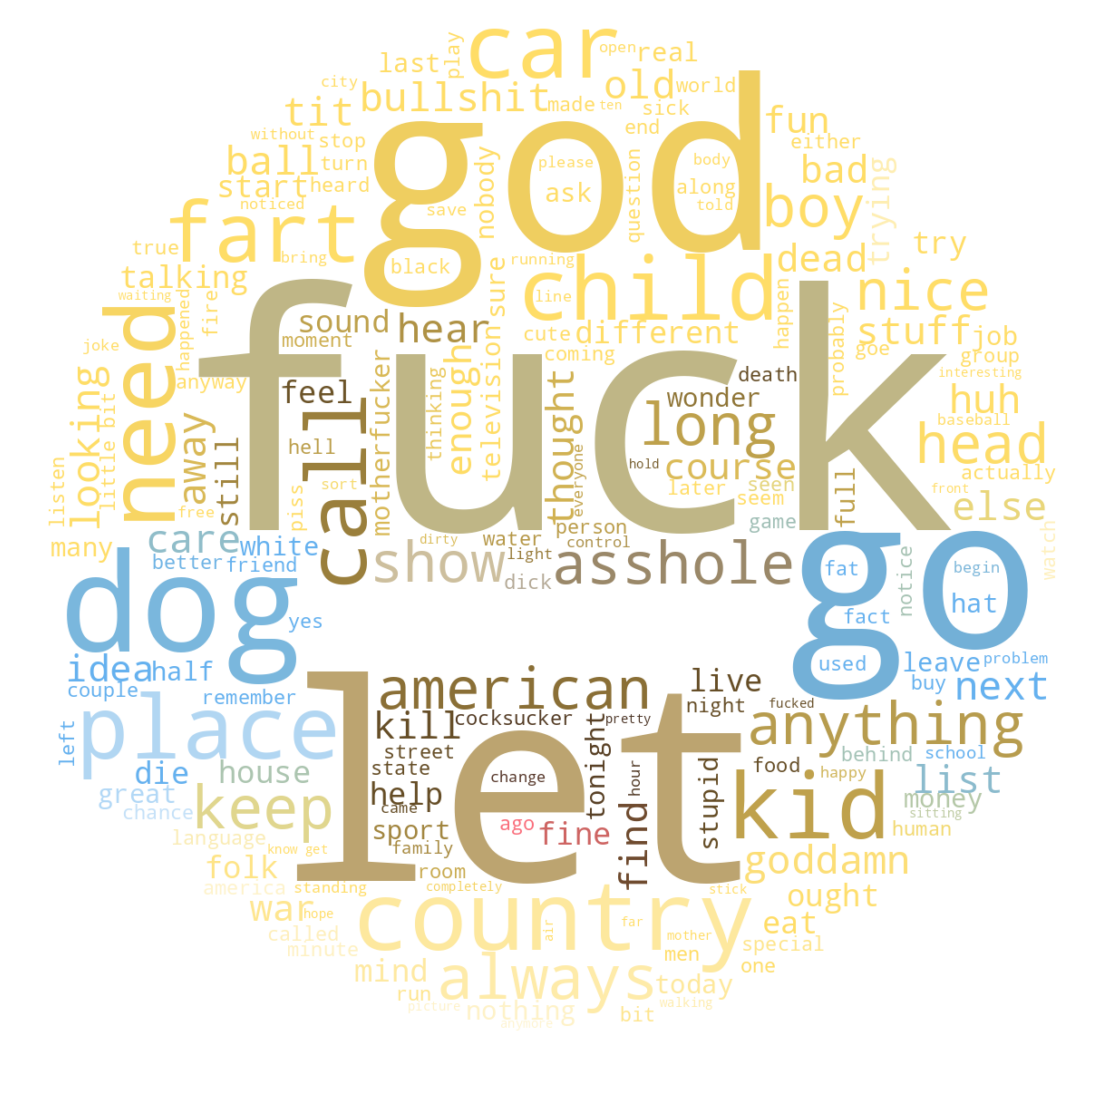

In [29]:
plot_from_bow(clean_df, 'george carlin', mask)

## Option 2: plot with string

In [38]:
def plot_some_cloud(df, condition, mask, option='artist'):
    '''
    search for index meeting conditions
    plot a word cloud
    
    to do: adding options of 'gender', 'artist' and 'age'
    '''
    index = get_index(df, option, condition)
    start = index[0]
    if len(index)>1:
        end = index[1]+1
    else:
        end = start+1
    
    t = df['full_transcript_clean'][start:end]
    selection = ' '.join(t)
    print(f"Plotting with transcripts of {len(selection)} characters...")
    word_cloud = wc.generate(selection)
    plot_cloud(word_cloud, mask)

Plotting with 2922 characters...


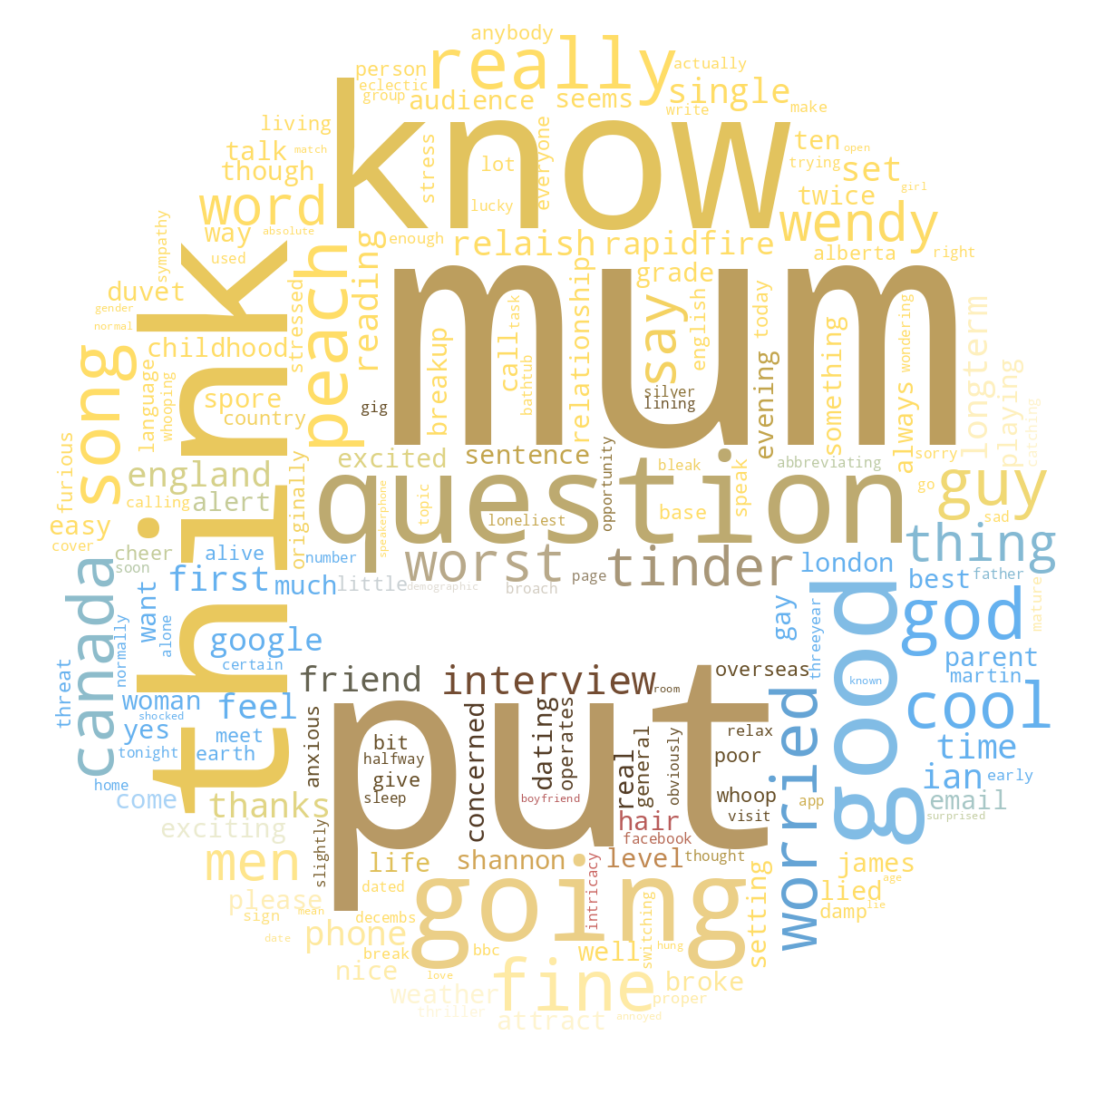

In [37]:
plot_some_cloud(clean_df, 'mae martin', mask)